In [106]:
import torch
import torch.nn as nn
import numpy as np
from model.C_CDN import C_CDN,DC_CDN
from model.CDCN import CDCN, SE_CDCN, ATT_CDCN, DATT_CDCN, BATT_CDCN, BSATT_CDCN, SATT_CDCN
from model.Finetune import Finetune_model
from torch.utils.data import DataLoader
from model.utils import CSDataset, CFASD_ZaloDataset, ZaloDataset, NUAADataset, StandardDataset, CFASDDataset
from torchmetrics.functional.classification import binary_confusion_matrix
from torchmetrics.functional.classification import binary_roc
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
from model import pl_model

In [2]:
# used_dataset = NUAADataset(root_dir='data/processed/test_img')
used_dataset = CFASDDataset(root_dir='data/processed/test_img', mode= 'val')

In [3]:
# val_model = Finetune_model(depth_model= CDCN(theta= 0.7), depth_weights= 'checkpoints/checkpoint_cdcn_cfas.pth',cls_weights= 'checkpoints/checkpoint_cls_sm.pth').cuda()
# val_model = SE_CDCN(se= True, sa= True).cuda()
# val_model.load_state_dict(torch.load('checkpoints/checkpoint_se_cdcn_se_sa_cfas.pth'))
# val_model.eval()

In [440]:
val_model = pl_model.load_from_checkpoint('checkpoints/checkpoint_att_cdcn_best.ckpt',model = ATT_CDCN(), train = 'all')
# val_model = pl_model.load_from_checkpoint('checkpoints/checkpoint_att_cdcn_ca_sa_last_cls_best.ckpt',model = ATT_CDCN(theta= 0.7,se = True, sa = True, pos= 'last')).cuda()
# val_model = pl_model.load_from_checkpoint('checkpoints/checkpoint_datt_cdcn_ca_sa_last_cls_best.ckpt',model = DATT_CDCN(theta= 0.7,se = True, sa = True, pos= 'last')).cuda()
# val_model = pl_model.load_from_checkpoint('checkpoints/checkpoint_batt_cdcn_best.ckpt',model = BATT_CDCN(theta= 0.7)).cuda()
# val_model = pl_model.load_from_checkpoint('checkpoints/checkpoint_bsatt_cdcn_best.ckpt',model = BSATT_CDCN(theta= 0.7)).cuda()

# val_model.train(True)

In [6]:
# class BSModel(nn.Module):
#     def __init__(self):
#         super(BSModel,self).__init__()
#         self.block1 = nn.Sequential(nn.Conv2d(3,64,3,1,1, bias= False),
#                                     nn.BatchNorm2d(64),
#                                     nn.ReLU(inplace= True),
#                                     nn.Conv2d(64,128,3,1,1, bias= False),
#                                     nn.BatchNorm2d(128),
#                                     nn.ReLU(inplace= True),
#                                     nn.Conv2d(128,64,3,1,1, bias= False),
#                                     nn.BatchNorm2d(64),
#                                     nn.ReLU(inplace= True),
#                                     nn.Conv2d(64,1,3,1,1, bias= False))
#         self.block2 = nn.Sequential(nn.MaxPool2d(8,8),
#                                     nn.Flatten(1),
#                                     nn.Linear(32*32,2),
#                                     nn.Softmax()
#                                     )
    
#     def forward(self,x):
#         out = self.block1(x)
#         out = self.block2(out)

#         return 'string',out

In [444]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# toy_model = BSModel()
# cam = GradCAM(model=toy_model, target_layers=[toy_model.block1[-1]], use_cuda=True)
# [val_model.net.lastconv1[0]]
# cam_net = GradCAM(model=val_model, target_layers=[val_model.net.lastconv1[0],val_model.net.lastconv2[0]], use_cuda=True)
# cam_cls = GradCAM(model=val_model, target_layers=[val_model.cls[1]], use_cuda=True)
# cam = GradCAM(model=val_model, target_layers=[val_model.net.lastconv1[0],val_model.net.lastconv2[0],val_model.cls[1]], use_cuda=True)

cam_net = HiResCAM(model=val_model, target_layers=[val_model.net.lastconv1[0],val_model.net.lastconv2[0]], use_cuda=True)
cam_cls = HiResCAM(model=val_model, target_layers=[val_model.cls[1]], use_cuda=True)
cam = HiResCAM(model=val_model, target_layers=[val_model.net.lastconv1[0],val_model.net.lastconv2[0],val_model.cls[1]], use_cuda=True)



In [8]:
# val_model.net.Block3

True label:  1
Predicted score: 0.0


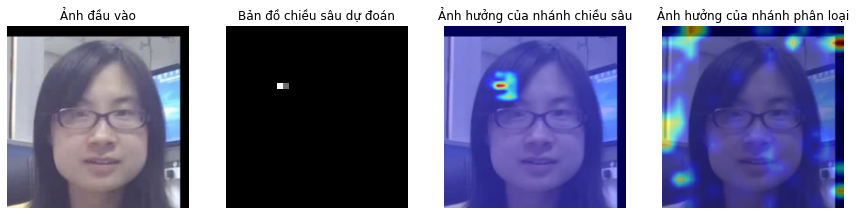

In [548]:

idx = np.random.randint(0,len(used_dataset))
in_tensor = used_dataset[idx][0]
targets = [ClassifierOutputTarget(used_dataset[idx][2])]
print('True label: ',used_dataset[idx][2])
print('Predicted score:', round(val_model(in_tensor.unsqueeze(0).cuda())[1][0][1].cpu().detach().numpy().mean(),3))
in_image = in_tensor.permute(1,2,0).numpy()
grayscale_cam_net = cam_net(input_tensor=in_tensor.unsqueeze(0).cuda(), targets=targets)
grayscale_cam_cls = cam_cls(input_tensor=in_tensor.unsqueeze(0).cuda(), targets=targets)
fig_1, ax_1 = plt.subplots(1,4, figsize= (15,10))
ax_1[0].imshow(in_tensor.permute(1,2,0).numpy())
ax_1[0].set_title('Ảnh đầu vào')
ax_1[0].axis('off')
ax_1[1].imshow(val_model(in_tensor.unsqueeze(0).cuda())[0].detach().squeeze(0).cpu().numpy(),cmap='gray')
ax_1[1].set_title('Bản đồ chiều sâu dự đoán')
ax_1[1].axis('off')
ax_1[2].imshow(show_cam_on_image(in_image,np.transpose(grayscale_cam_net,(1,2,0)),use_rgb= True))
ax_1[2].set_title('Ảnh hưởng của nhánh chiều sâu')
ax_1[2].axis('off')
ax_1[3].imshow(show_cam_on_image(in_image,np.transpose(grayscale_cam_cls,(1,2,0)),use_rgb= True))
ax_1[3].set_title('Ảnh hưởng của nhánh phân loại')
ax_1[3].axis('off');

# fig_1

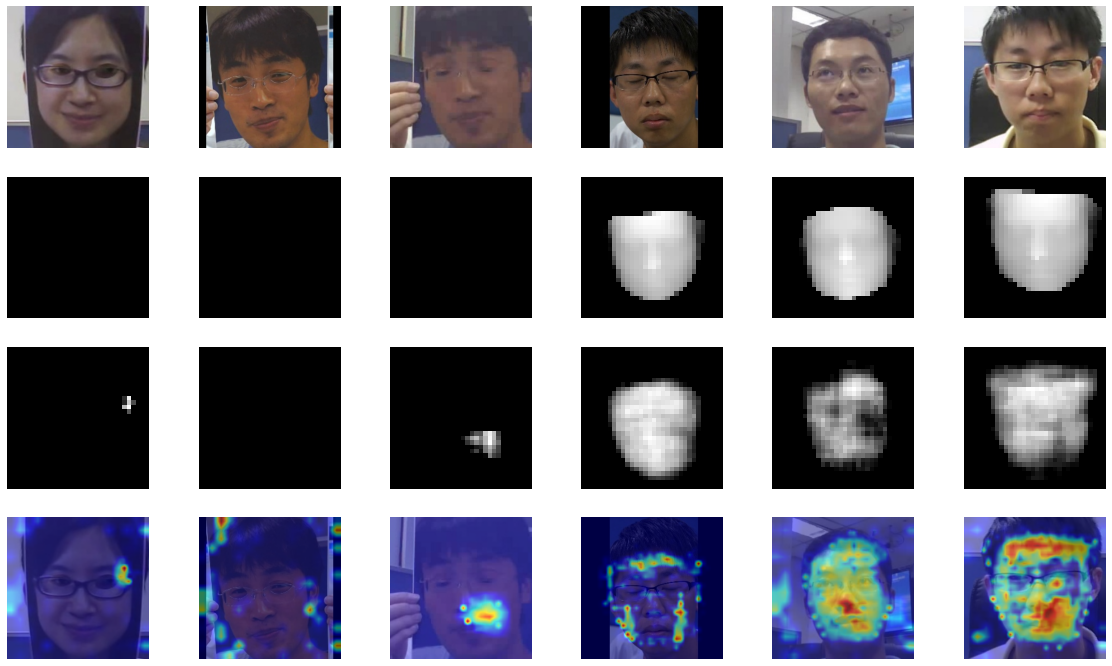

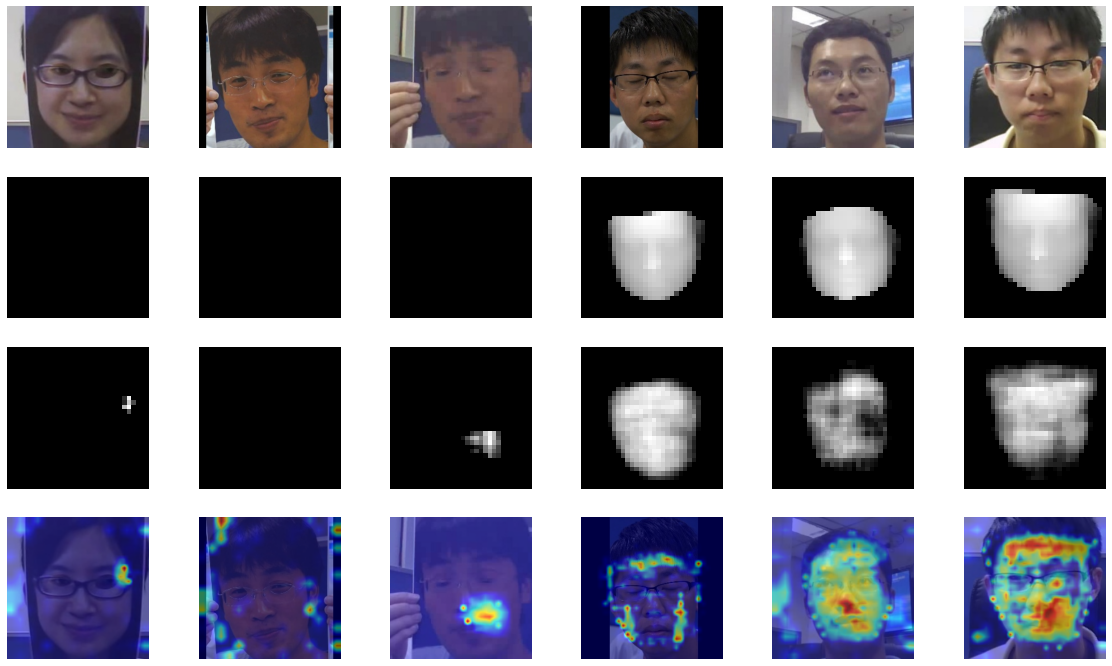

In [549]:
fig,ax = plt.subplots(4,6, figsize= (20,12));

i = 0
while i < 6:
    idx = np.random.randint(0,len(used_dataset))
    if used_dataset[idx][2] == 0 and i<3:
        ax[0,i].imshow(used_dataset[idx][0].permute(1,2,0).numpy());
        ax[0,i].axis('off');
        ax[1,i].imshow(used_dataset[idx][1].numpy(), cmap= 'gray');
        ax[1,i].axis('off');
        ax[2,i].imshow(val_model(used_dataset[idx][0].unsqueeze(0).cuda())[0].detach().squeeze(0).cpu().numpy(), cmap= 'gray');
        ax[2,i].axis('off');
        # grayscale_cam = (cam_cls(input_tensor=used_dataset[idx][0].unsqueeze(0).cuda(), targets=targets) + cam_net(input_tensor=used_dataset[idx][0].unsqueeze(0).cuda(), targets=targets))/2
        # grayscale_cam = cam_cls(input_tensor=used_dataset[idx][0].unsqueeze(0).cuda(), targets=targets)
        grayscale_cam = cam(input_tensor=used_dataset[idx][0].unsqueeze(0).cuda(), targets=targets)
        ax[3,i].imshow(show_cam_on_image(used_dataset[idx][0].permute(1,2,0).numpy(),np.transpose(grayscale_cam,(1,2,0)),use_rgb= True));
        ax[3,i].axis('off');
        i += 1
    if used_dataset[idx][2] == 1 and i>=3:
        ax[0,i].imshow(used_dataset[idx][0].permute(1,2,0).numpy());
        ax[0,i].axis('off');
        ax[1,i].imshow(used_dataset[idx][1].numpy(), cmap= 'gray');
        ax[1,i].axis('off');
        ax[2,i].imshow(val_model(used_dataset[idx][0].unsqueeze(0).cuda())[0].detach().squeeze(0).cpu().numpy(), cmap= 'gray');
        ax[2,i].axis('off');
        # grayscale_cam = (cam_cls(input_tensor=used_dataset[idx][0].unsqueeze(0).cuda(), targets=targets) + cam_net(input_tensor=used_dataset[idx][0].unsqueeze(0).cuda(), targets=targets))/2
        # grayscale_cam = cam_cls(input_tensor=used_dataset[idx][0].unsqueeze(0).cuda(), targets=targets)
        grayscale_cam = cam(input_tensor=used_dataset[idx][0].unsqueeze(0).cuda(), targets=targets)
        ax[3,i].imshow(show_cam_on_image(used_dataset[idx][0].permute(1,2,0).numpy(),np.transpose(grayscale_cam,(1,2,0)),use_rgb= True));
        ax[3,i].axis('off');
        i += 1
fig

In [11]:
# import torch
# import torch.nn.functional as F
# import numpy as np
# from model.C_CDN import C_CDN,DC_CDN
# from model.CDCN import CDCN, SE_CDCN, ATT_CDCN
# from model.Finetune import Finetune_model, Finetune_modelv2
# from torch.utils.data import DataLoader
# from model.utils import CSDataset, CFASD_ZaloDataset, ZaloDataset, NUAADataset, StandardDataset, CFASDDataset
# from torchmetrics.functional.classification import binary_confusion_matrix
# from torchmetrics.functional.classification import binary_roc
# from tqdm import tqdm
# import matplotlib.pyplot as plt
# from model import pl_model

# torch.manual_seed(42)

# val_model = pl_model.load_from_checkpoint('checkpoints/checkpoint_att_cdcn_best.ckpt',model = ATT_CDCN(theta= 0.7,se = False, sa = False, pos= 'last')).cuda()
# # val_model = Finetune_model(depth_model= ATT_CDCN(se= True,sa= True), depth_weights= 'checkpoints/checkpoint_att_cdcn_se_sa_cfas.pth',cls_weights= 'checkpoints/checkpoint_cls_sm.pth').cuda()
# # val_model = Finetune_model(depth_model= CDCN(theta= 0.5), depth_weights= 'checkpoints/checkpoint_cdcn_cfas_t5.pth',cls_weights= 'checkpoints/checkpoint_cls_sm.pth').cuda()
# sampler = None


# pred = torch.Tensor().cuda()
# target = torch.Tensor().cuda()
# # minicsdata = [csdata[i] for i in range(2500,5000)]
# # used_dataset = NUAADataset(root_dir = './data/processed/NUAA/test')
# used_dataset = CFASDDataset(root_dir='data/processed/test_img', mode= 'val')
# # used_dataset = ZaloDataset(root_dir = './data/processed/zalo_data')
# print("Calculating class distribution...")
# cls_dist = np.mean([sample[2] for sample in tqdm(used_dataset)])

# print("Assigning weight to samples...")
# weight_tensor = torch.Tensor([ (1-cls_dist) if used_dataset[i][2] == 1 else cls_dist for i in tqdm(range(used_dataset.__len__())) ])
# sampler = torch.utils.data.WeightedRandomSampler(weight_tensor,int(used_dataset.__len__()*1), replacement=True)
# val_model.eval()
# val_model.net.eval()
# val_loader = DataLoader(used_dataset, sampler= sampler, batch_size = 4, shuffle= False)

print("Inferencing...")
# with torch.no_grad():
#     for idx, batch in enumerate(tqdm(val_loader)):
#         sample, spoof_label = batch[0].float().cuda(), batch[2].float().cuda()
#         spoof_label = F.one_hot(spoof_label.to(torch.int64),2).float()
#         pred = torch.cat([pred, val_model(sample).squeeze(1)], dim = 0)
#         target = torch.cat([target, spoof_label], dim = 0)

# with torch.no_grad():
#     for idx, batch in enumerate(tqdm(val_loader)):
#         sample, spoof_label = batch[0].float().cuda(), batch[2].float().cuda()
#         spoof_label = F.one_hot(spoof_label.to(torch.int64),2).float()
#         print(sample.shape)
#         pred = torch.cat([pred, val_model(sample)[1][1]], dim = 0)
#         if idx == 0:
#             break
#         target = torch.cat([target, spoof_label[1]], dim = 0)
#         # print(pred, target)

# # print(target.shape)

# roc = binary_roc(pred, target, thresholds = None)
# fpr, tpr, threshold = roc[0].cpu(), roc[1].cpu(), roc[2].cpu()



# best_threshold = threshold[np.argmin((((1 - tpr)+fpr)/2).numpy())]

# # confusion_matrix = binary_confusion_matrix(pred, target, threshold= best_threshold.item())
# confusion_matrix = binary_confusion_matrix(pred, target, threshold= .5)

# print(confusion_matrix)

# tp, fn, fp, tn = confusion_matrix[0,0], confusion_matrix[0,1], confusion_matrix[1,0], confusion_matrix[1,1]

# apcer = fn/(tp+fn)
# bpcer = fp/(tn+fp)
# acer= (apcer+bpcer)/2
# print("Best threshold:",best_threshold.item())
# print("APCER:",apcer.item())
# print("BPCER",bpcer.item())
# print("ACER",acer.item())




# plt.plot(fpr,fpr, 'r--')
# plt.plot(fpr,tpr)
# plt.title('ROC curve')
# plt.show()

Inferencing...


In [12]:
# data = next(iter(val_loader))
# # print((val_model(data[0].cuda())[1].T)[1])
# print(data[2])
# del data

In [13]:
# x1= torch.rand(4,2)
# x2 = torch.rand(4,2)

# (torch.cat([x1,x2],dim=0).T)[1]